In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_breast import BreastPathQDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian

matplotlib.rcParams['font.size'] = 8

In [2]:
base_model = 'densenet201'

In [3]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [4]:
batch_size = 16
resize_to = (384, 384)

data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./data_indices/breastpathq_valid_indices.pth')
test_indices = torch.load('./data_indices/breastpathq_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([600])
torch.Size([1200])


In [5]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=1).to(device)

checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_breastpathq.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 478 from
/media/fastdata/laves/regression_snapshots/densenet201_gaussian_breastpathq.pth.tar


In [6]:
model.eval()
y_p_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

        y_p_calib.append(y_p.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

100%|██████████| 38/38 [01:32<00:00,  2.44s/it]


In [7]:
y_p_calib = torch.cat(y_p_calib, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib = y_p_calib.mean(dim=1)
var_calib = torch.cat(vars_calib, dim=0)
logvars_calib = torch.cat(logvars_calib, dim=1).permute(1,0,2)
logvar_calib = logvars_calib.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [8]:
err_calib = (target_calib-mu_calib).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_calib = (y_p_calib-target_calib.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp().mean(dim=1, keepdim=True)
uncert_calib_epistemic = var_calib.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [9]:
print((err_calib**2).mean())
print(errvar_calib.mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

err_calib = errvar_calib.sqrt()

tensor(0.0066, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0247, device='cuda:0')


<IPython.core.display.Javascript object>


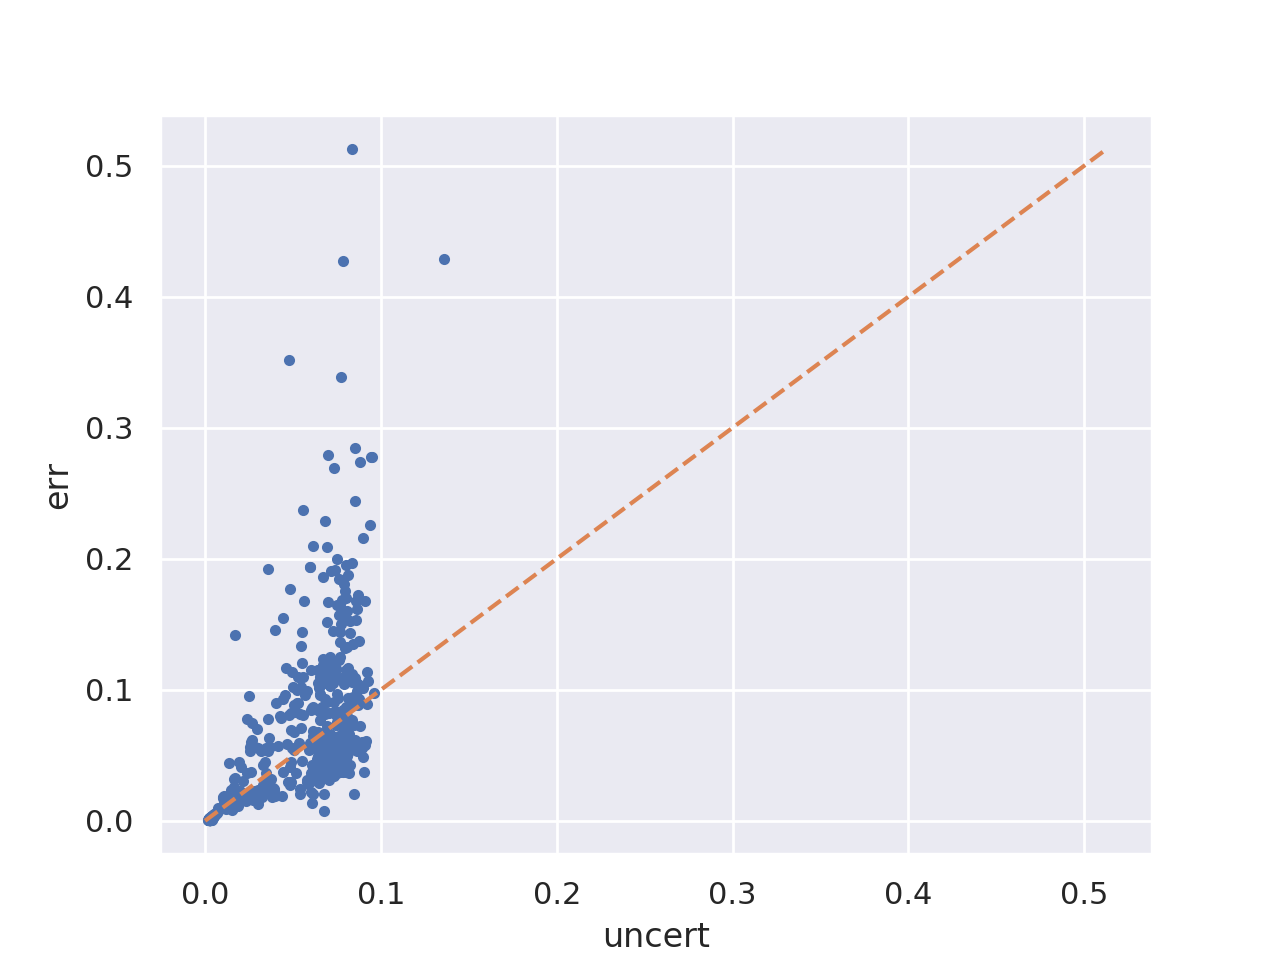

In [10]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [66]:
class AuxModel(torch.nn.Module):
    def __init__(self, channels, hidden=16):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels, hidden, bias=True)
        self.fc = torch.nn.Linear(hidden, channels, bias=True)

    def forward(self, x):
        x = 2*(x.log())
        y = self.linear1(x).relu()
        y = self.fc(y)
        
        if self.training:
            return y
        else:
            return (0.5*y).exp()

In [108]:
# find optimal aux
aux4 = AuxModel(1, hidden=2).to(device)
aux_opt4 = torch.optim.Adam(aux4.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net4 = optim.lr_scheduler.ReduceLROnPlateau(aux_opt4, patience=100, factor=0.1)

aux4.train()
for i in range(2000):
    aux_opt4.zero_grad()
    loss4 = nll_criterion_gaussian(mu_calib, aux4(uncert_calib), target_calib)
    loss4.backward()
    aux_opt4.step()
    lr_scheduler_net4.step(loss.item())

print(loss4.item())

-4.012269973754883


In [109]:
# find optimal aux
aux8 = AuxModel(1, hidden=3).to(device)
aux_opt8 = torch.optim.Adam(aux8.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net8 = optim.lr_scheduler.ReduceLROnPlateau(aux_opt8, patience=100, factor=0.1)

aux8.train()
for i in range(2000):
    aux_opt8.zero_grad()
    loss8 = nll_criterion_gaussian(mu_calib, aux8(uncert_calib), target_calib)
    loss8.backward()
    aux_opt8.step()
    lr_scheduler_net8.step(loss.item())

print(loss8.item())

-6.088984489440918


In [111]:
# find optimal aux
aux16 = AuxModel(1, hidden=4).to(device)
aux_opt16 = torch.optim.Adam(aux16.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net16 = optim.lr_scheduler.ReduceLROnPlateau(aux_opt16, patience=100, factor=0.1)

aux16.train()
for i in range(2000):
    aux_opt16.zero_grad()
    loss16 = nll_criterion_gaussian(mu_calib, aux16(uncert_calib), target_calib)
    loss16.backward()
    aux_opt16.step()
    lr_scheduler_net16.step(loss.item())

print(loss16.item())

-6.089646339416504


In [83]:
aux4.train()
aux8.train()
aux16.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux4(uncert_calib), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux8(uncert_calib), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux16(uncert_calib), target_calib).item())
aux4.eval()
aux8.eval()
aux16.eval()

-5.637300491333008
-6.089656829833984
-6.089656352996826
-6.089656352996826


AuxModel(
  (linear1): Linear(in_features=1, out_features=8, bias=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [84]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux4(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux8(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux16(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.22270630300045013
0.19270560145378113
0.19269311428070068
0.1927126944065094


<IPython.core.display.Javascript object>


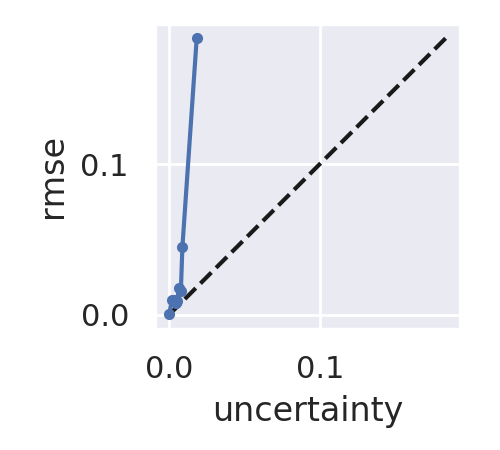

0.4345737397670746


In [85]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


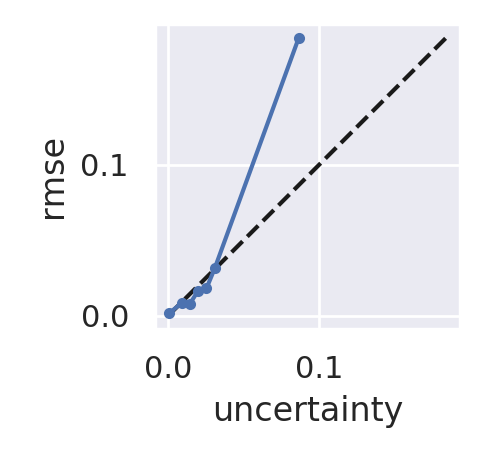

0.28880853205919266


<IPython.core.display.Javascript object>


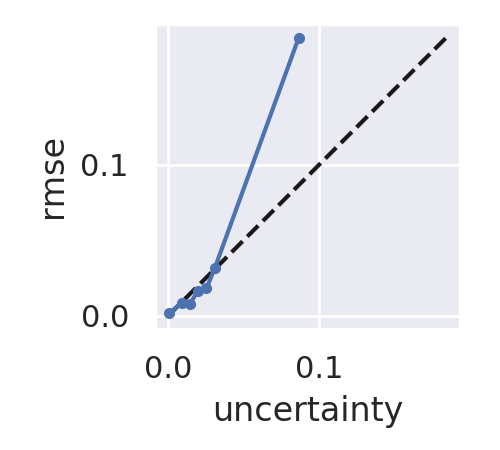

0.28840943705290556


<IPython.core.display.Javascript object>


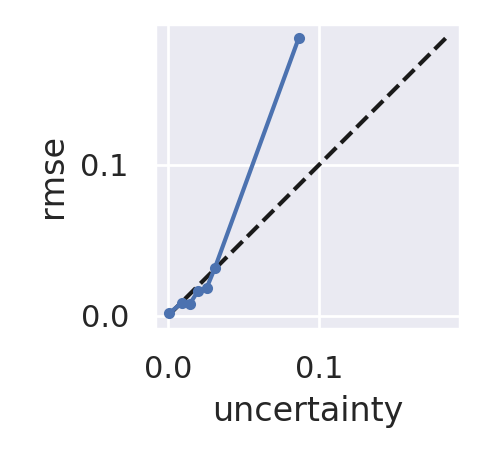

0.2890342380851507


In [86]:
n_bins = 15

uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux4(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux8(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux16(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

In [19]:
y_p_test_list = []
mu_test_list = []
var_test_list = []
logvars_test_list = []
logvar_test_list = []
target_test_list = []

for i in range(2):
    y_p_test = []
    mus_test = []
    vars_test = []
    logvars_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

            y_p_test.append(y_p.detach())
            vars_test.append(var_bayesian.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())

        y_p_test = torch.cat(y_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = y_p_test.mean(dim=1)
        var_test = torch.cat(vars_test, dim=0)
        logvars_test = torch.cat(logvars_test, dim=1).permute(1,0,2)
        logvar_test = logvars_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        y_p_test_list.append(y_p_test)
        mu_test_list.append(mu_test)
        var_test_list.append(var_test)
        logvars_test_list.append(logvars_test)
        logvar_test_list.append(logvar_test)
        target_test_list.append(target_test)

100%|██████████| 75/75 [03:05<00:00,  2.48s/it]


In [112]:
err_test = [(target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt() for target_test, mu_test in zip(target_test_list, mu_test_list)]
errvar_test = [(y_p_test-target_test.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1) for target_test, y_p_test in zip(target_test_list, y_p_test_list)]

uncert_aleatoric_test = [logvar_test.exp().mean(dim=1, keepdim=True) for logvar_test in logvar_test_list]
uncert_epistemic_test = [var_test.mean(dim=1, keepdim=True) for var_test in var_test_list]

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]

In [113]:
for i in range(len(err_test)):
    print((err_test[i]**2).mean())
    print(errvar_test[i].mean())
    print((uncert_test[i]**2).mean())
    print()

err_test = [errvar.sqrt() for errvar in errvar_test]

tensor(0.0061, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0032, device='cuda:0')

tensor(0.0061, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0032, device='cuda:0')



In [114]:
aux4.train()
aux8.train()
aux16.train()
for i in range(len(mu_test_list)):
    print(nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux4(uncert_test[i]), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux8(uncert_test[i]), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux16(uncert_test[i]), target_test_list[i]).item())
    print()
aux4.eval()
aux8.eval()
aux16.eval()

-5.664314270019531
-4.076533317565918
-6.024449348449707
-6.022307872772217

-5.673004150390625
-4.074256420135498
-6.045075416564941
-6.043439865112305



AuxModel(
  (linear1): Linear(in_features=1, out_features=4, bias=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [115]:
for i in range(len(mu_test_list)):
    print(torch.nn.functional.mse_loss(uncert_test[i]**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux4(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux8(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux16(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print()

0.3024866580963135
0.31680428981781006
0.28214219212532043
0.28634846210479736

0.3006688356399536
0.31437331438064575
0.27688801288604736
0.28053417801856995



<IPython.core.display.Javascript object>


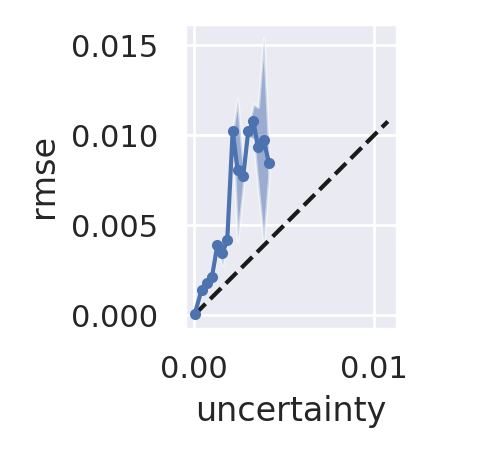

0.3804226219654083 0.0016670343466103077


In [116]:
if base_model == 'resnet101':
    uce_range = [0, 0.0043]
elif base_model == 'densenet201':
    uce_range = [0, 0.0043]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.0049]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
for i in range(len(err_test)):
    uce_uncal, _, _, _ = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    _, err_uncal, uncert_uncal, _ = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())

plot_uncert_multi(err_uncal_list, uncert_uncal_list)
print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())

In [128]:
aux4(uncert_test[i])**2

tensor([[0.0075],
        [0.0075],
        [0.0075],
        ...,
        [0.0075],
        [0.0075],
        [0.0075]], device='cuda:0', grad_fn=<PowBackward0>)

0.007454796694219112
0.007454796694219112
0.043212950229644775 0.0005678629386238754


<IPython.core.display.Javascript object>


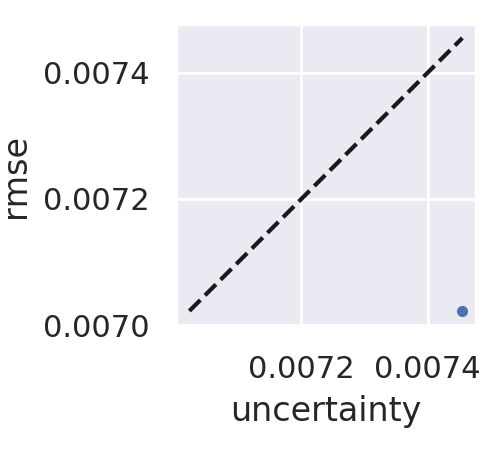

0.052805595099925995
0.05521208047866821
0.30141204595565796 0.014109564013779163


<IPython.core.display.Javascript object>


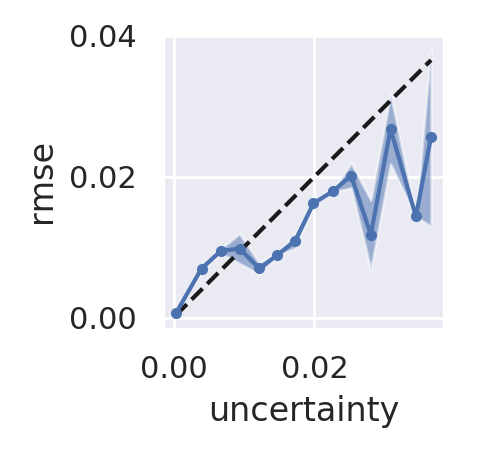

0.052805595099925995
0.05521208047866821
0.3292129635810852 0.02225739136338234


<IPython.core.display.Javascript object>


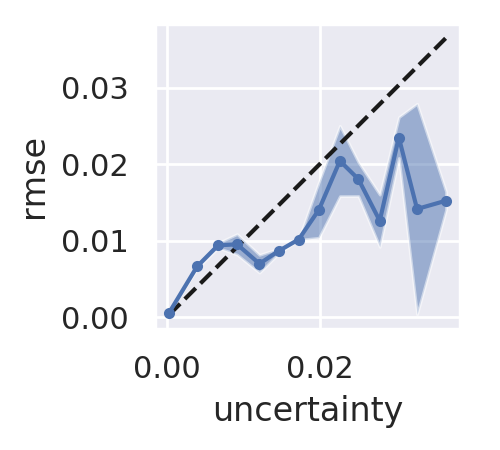

(<Figure size 250x225 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84d7bab4a8>)

In [127]:
uce_aux4_list = []
err_aux4_list = []
uncert_aux4_list = []
for i in range(len(err_test)):
    print((aux4(uncert_test[i])**2).max().item())
    uce_aux, err_aux, uncert_aux, _ = uceloss(err_test[i]**2, aux4(uncert_test[i])**2, n_bins=n_bins, range=[0, 0.008])
    uce_aux4_list.append(uce_aux.cpu())
    err_aux4_list.append(err_aux.cpu())
    uncert_aux4_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux4_list)*100).mean().item(), (torch.stack(uce_aux4_list)*100).var().sqrt().item())
plot_uncert_multi(err_aux4_list, uncert_aux4_list)

uce_aux8_list = []
err_aux8_list = []
uncert_aux8_list = []
for i in range(len(err_test)):
    print((aux8(uncert_test[i])**2).max().item())
    uce_aux, err_aux, uncert_aux, _ = uceloss(err_test[i]**2, aux8(uncert_test[i])**2, n_bins=n_bins, range=[0, 0.04])
    uce_aux8_list.append(uce_aux.cpu())
    err_aux8_list.append(err_aux.cpu())
    uncert_aux8_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux8_list)*100).mean().item(), (torch.stack(uce_aux8_list)*100).var().sqrt().item())
plot_uncert_multi(err_aux8_list, uncert_aux8_list)

uce_aux16_list = []
err_aux16_list = []
uncert_aux16_list = []
for i in range(len(err_test)):
    print((aux8(uncert_test[i])**2).max().item())
    uce_aux, err_aux, uncert_aux, _ = uceloss(err_test[i]**2, aux16(uncert_test[i])**2, n_bins=n_bins, range=[0, 0.04])
    uce_aux16_list.append(uce_aux.cpu())
    err_aux16_list.append(err_aux.cpu())
    uncert_aux16_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux16_list)*100).mean().item(), (torch.stack(uce_aux16_list)*100).var().sqrt().item()) 
plot_uncert_multi(err_aux16_list, uncert_aux16_list)

In [129]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [130]:
def save_log(base_model):
    with open(f"results_ablation_breastpathq_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux4", file=f)
        print("NLL", file=f)
        aux4.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux4(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux4.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux4_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux4_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux8", file=f)
        print("NLL", file=f)
        aux8.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux8(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux8.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux8_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux8_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux16", file=f)
        print("NLL", file=f)
        aux16.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux16(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux16.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux16_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux16_list)*100).var().sqrt().item(), file=f)
        print("", file=f)

<IPython.core.display.Javascript object>


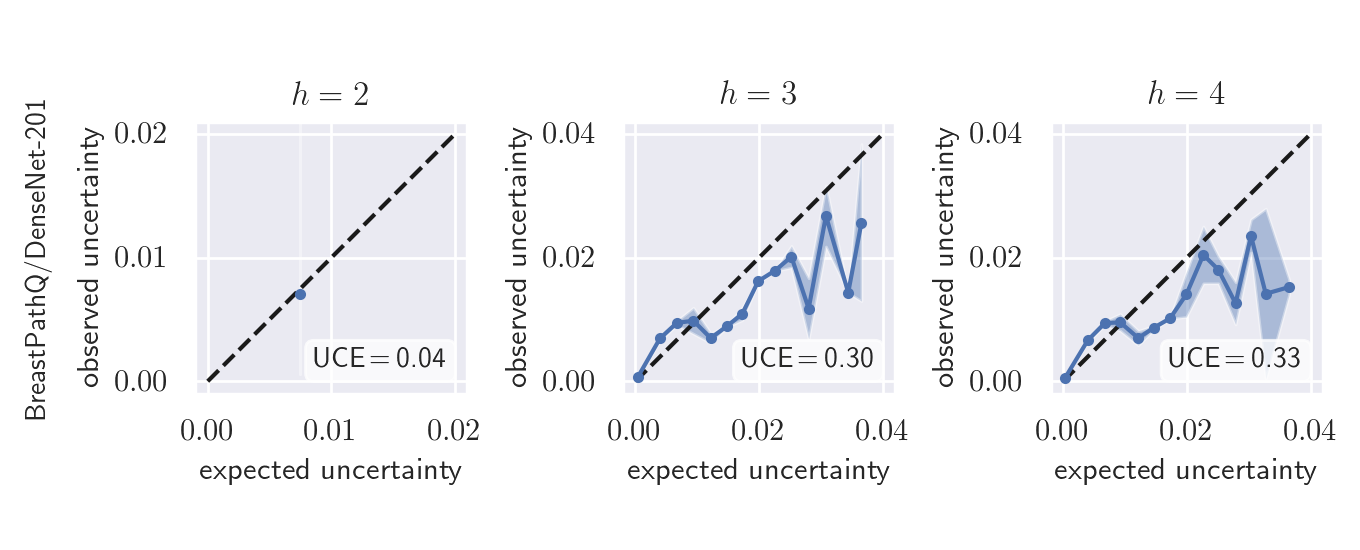

In [161]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_aux4 = torch.stack(err_aux4_list).mean(dim=0).cpu()
    err_aux4_var = torch.stack(err_aux4_list).var(dim=0).sqrt().cpu()
    uncert_aux4 = torch.stack(uncert_aux4_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.02], [0, 0.02], 'k--')
    ax[0].plot(uncert_aux4, err_aux4, marker='.', label='uncal')
    ax[0].fill_between(uncert_aux4, err_aux-err_aux4_var, err_aux4+err_aux4_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.001, 0.021])
    ax[0].set_ylim([-0.001, 0.021])
    ax[0].set_xticks([0, 0.01, 0.02])
    ax[0].set_yticks([0, 0.01, 0.02])
    ax[0].set_aspect(1)
    ax[0].set_title(r'$ h = 2 $')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux4_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr1, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux8 = torch.stack(err_aux8_list).mean(dim=0).cpu()
    err_aux8_var = torch.stack(err_aux8_list).var(dim=0).sqrt().cpu()
    uncert_aux8 = torch.stack(uncert_aux8_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.04], [0, 0.04], 'k--')
    ax[1].plot(uncert_aux8, err_aux8, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux8, err_aux8-err_aux8_var, err_aux8+err_aux8_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.002, 0.042])
    ax[1].set_ylim([-0.002, 0.042])
    ax[1].set_xticks([0, 0.02, 0.04])
    ax[1].set_yticks([0, 0.02, 0.04])
    ax[1].set_aspect(1)
    ax[1].set_title(r'$ h = 3 $')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux8_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )
    
    err_aux16 = torch.stack(err_aux16_list).mean(dim=0).cpu()
    err_aux16_var = torch.stack(err_aux16_list).var(dim=0).sqrt().cpu()
    uncert_aux16 = torch.stack(uncert_aux16_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.04], [0, 0.04], 'k--')
    ax[2].plot(uncert_aux16, err_aux16, marker='.', label='uncal')
    ax[2].fill_between(uncert_aux16, err_aux16-err_aux16_var, err_aux16+err_aux16_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.002, 0.042])
    ax[2].set_ylim([-0.002, 0.042])
    ax[2].set_xticks([0, 0.02, 0.04])
    ax[2].set_yticks([0, 0.02, 0.04])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ h = 4 $')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux16_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr1, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BreastPathQ/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_aux_ablation_breastpathq_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    #save_log(base_model)